# Auto Feature Engineering & more

## Introduction  

This Notebook presents two key components of the Auto ML pipeline provided by Khiops:  

- [Auto Feature Engineering][auto_feature_engineering] which automatically generates a large number of informative aggregates from secondary tables of a multi-table training set,  
- [Parsimonious Training][parsimonious_training] which trains a model by selecting a small subset of independant and highly informative variables (native or aggregates).  

[auto_feature_engineering]: ../../../learn/autofeature_engineering/
[parsimonious_training]: ../../../learn/learning_models/


The sequencing of these two steps greatly improves *model interpretability*. To be more precise, data representation varies in size over the whole pipeline (see the figure bellow). On the one hand, Auto Feature Engineering explores a large number of aggregates, enriching the data representation with useful but possibly redundant information. On the other hand, Parsimonious Training reduces the data representation by selecting a *few informative and independant variables*. The contributions of the selected variables are almost additive, since their interactions are reduced to a minimum, making the model easy to interpret.

![](../../../assets/images/parcimonious-training-big-picture.webp)

Combined with the fact that the aggregates generated in the Auto Feature Engineering step have *explicit names*, make the models produced by Khiops very easy to understand. A *visualization tool* is provided for this purpose, making it possible to understand and visualize the entire Auto ML pipeline, from optimal encoding to model evaluation.

In this notebook, we'll explore the Khiops' Auto Feature Engineering capabilities which is unrivalled considering overfitting prevention, interpretability and scalability. We demonstrate that khiops' Auto Feature Engineering algorithm can be coupled to any classifier (here, using an LGBM classifier), dramatically improving the productivity of data scientists who no longer have to do feature engineering by hand. Finally, we demonstrate the benefits of using the full pipeline provided by Khiops, to leverage parsimonious training and considerably increase model interpretability. 

We will illustrate this using "Accidents" dataset. This dataset describes the characteristics of road accidents that occurred in France in 2018. It has three tables with the following schema:

```
Accidents
|
| -- 1:n -- Vehicles
              |
              |-- 1:n -- Users
```

## Installation and set up

If you do not use our offical `khiops-notebook` Jupyter Docker image, you may have to install khiops locally using `conda`:

In [1]:
#!conda install -c khiops khiops

For the experiments, you also need some external libraries you can install via `pip`:

In [2]:
# Installation of external libraries
#!pip install matplotlib seaborn pycaret

We now import all the dependencies here:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from khiops.sklearn import KhiopsClassifier
from khiops.sklearn import KhiopsEncoder

from pycaret.classification import *

/opt/homebrew/Caskroom/miniconda/base/envs/benchmark/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Import and preparation of data

For this notebook, we use the "Accident" French Dataset. More details on the [French Goverment Open Data Site][Open Data Site].

[Open Data Site]: https://www.data.gouv.fr/fr/datasets/base-de-donnees-accidents-corporels-de-la-circulation/

This dataset is also available on our [khiops-sample][khiops-sample] repository on Github.

[khiops-sample]:https://github.com/KhiopsML/khiops-samples/

This dataset has four tables `Accident`, `Vehicle`, `Place` and `User` organized in the following
relational schema.

```
Accident
|
| -- 1:n -- Vehicle
|             |
|             |-- 1:n -- User
|
| -- 1:1 -- Place
```

Each accident has associated one or more vehicles and one unique place. The vehicles involved in an
accident have in turn associated one or more road users (passengers and pedestrians).

The fields of each table are self-explanatory, and so are their values. The
target in the `Accident` table is the constructed variable `Gravity` which is set to `Lethal` if
there was at least one casualty in the accident.

In [4]:
# Load data directly from our GitHub
url_accident = "https://raw.githubusercontent.com/KhiopsML/khiops-samples/main/AccidentsSummary/Accidents.txt"

# Read the data into a Pandas DataFrame
df_accident = pd.read_csv(url_accident, delimiter='\t',encoding='latin-1')

# Display the first 10 records from the dataset
df_accident.head(5)

,AccidentId,Gravity,Date,Hour,Light,Department,Commune,InAgglomeration,IntersectionType,Weather,CollisionType,PostalAddress
0,201800000001,NonLethal,2018-01-24,15:05:00,Daylight,590,5,No,Y-type,Normal,2Vehicles-BehindVehicles-Frontal,route des Ansereuilles
1,201800000002,NonLethal,2018-02-12,10:15:00,Daylight,590,11,Yes,Square,VeryGood,NoCollision,Place du général de Gaul
2,201800000003,NonLethal,2018-03-04,11:35:00,Daylight,590,477,Yes,T-type,Normal,NoCollision,Rue nationale
3,201800000004,NonLethal,2018-05-05,17:35:00,Daylight,590,52,Yes,NoIntersection,VeryGood,2Vehicles-Side,30 rue Jules Guesde
4,201800000005,NonLethal,2018-06-26,16:05:00,Daylight,590,477,Yes,NoIntersection,Normal,2Vehicles-Side,72 rue Victor Hugo


In [5]:
# Load data directly from our GitHub
url_vehicule = "https://raw.githubusercontent.com/KhiopsML/khiops-samples/main/AccidentsSummary/Vehicles.txt"

# Read the data into a Pandas DataFrame
df_vehicule = pd.read_csv(url_vehicule, delimiter='\t')

# Display the first 10 records from the dataset
df_vehicule.head(5)

,AccidentId,VehicleId,Direction,Category,PassengerNumber,FixedObstacle,MobileObstacle,ImpactPoint,Maneuver
0,201800000001,A01,Unknown,Car<=3.5T,0,NaN,Vehicle,RightFront,TurnToLeft
1,201800000001,B01,Unknown,Car<=3.5T,0,NaN,Vehicle,LeftFront,NoDirectionChange
2,201800000002,A01,Unknown,Car<=3.5T,0,NaN,Pedestrian,NaN,NoDirectionChange
3,201800000003,A01,Unknown,Motorbike>125cm3,0,StationaryVehicle,Vehicle,Front,NoDirectionChange
4,201800000003,B01,Unknown,Car<=3.5T,0,NaN,Vehicle,LeftSide,TurnToLeft


In [6]:
# Load data directly from our GitHub
url_user = "https://raw.githubusercontent.com/KhiopsML/khiops-samples/main/Accidents/Users.txt"

# Read the data into a Pandas DataFrame
df_user = pd.read_csv(url_user, delimiter='\t')

# Display the first 10 records from the dataset
df_user.head(10)

,AccidentId,VehicleId,Seat,Category,Gravity,Gender,TripReason,SafetyDevice,SafetyDeviceUsed,PedestrianLocation,PedestrianAction,PedestrianCompany,BirthYear
0,201800000001,A01,1.0,Driver,Unscathed,Male,Leisure,SeatBelt,Yes,NaN,NaN,Unknown,1960.0
1,201800000001,B01,1.0,Driver,InjuredAndHospitalized,Male,NaN,SeatBelt,Yes,NaN,NaN,Unknown,1928.0
2,201800000002,A01,1.0,Driver,Unscathed,Male,NaN,SeatBelt,Yes,NaN,NaN,Unknown,1947.0
3,201800000002,A01,NaN,Pedestrian,MildlyInjured,Male,NaN,Helmet,NaN,OnLane<=OnSidewalk0mCrossing,Crossing,Alone,1959.0
4,201800000003,A01,1.0,Driver,InjuredAndHospitalized,Male,Leisure,Helmet,Yes,NaN,NaN,Unknown,1987.0
5,201800000003,C01,1.0,Driver,Unscathed,Male,NaN,ChildrenDevice,NaN,NaN,NaN,Unknown,1977.0
6,201800000004,A01,1.0,Driver,Unscathed,Male,Leisure,SeatBelt,Yes,NaN,NaN,Unknown,1982.0
7,201800000004,B01,1.0,Driver,InjuredAndHospitalized,Male,Leisure,Helmet,NaN,NaN,NaN,Unknown,2013.0
8,201800000005,A01,1.0,Driver,MildlyInjured,Male,Leisure,Helmet,Yes,NaN,NaN,Unknown,2001.0
9,201800000005,B01,1.0,Driver,Unscathed,Male,Leisure,SeatBelt,Yes,NaN,NaN,Unknown,1946.0


In [7]:
# Load data directly from our GitHub
url_place = "https://raw.githubusercontent.com/KhiopsML/khiops-samples/main/Accidents/Places.txt"

# Read the data into a Pandas DataFrame
df_place = pd.read_csv(url_place, delimiter='\t')

# Display the first 10 records from the dataset
df_place.head(10)

,AccidentId,RoadType,RoadNumber,RoadSecNumber,RoadLetter,Circulation,LaneNumber,SpecialLane,Slope,RoadMarkerId,RoadMarkerDistance,Layout,StripWidth,LaneWidth,SurfaceCondition,Infrastructure,Localization,SchoolNear
0,201800000001,Departamental,41,NaN,C,TwoWay,2.0,0,Flat,NaN,NaN,RightCurve,NaN,NaN,Normal,Unknown,Lane,0.0
1,201800000002,Communal,41,NaN,D,TwoWay,2.0,0,Flat,NaN,NaN,LeftCurve,NaN,NaN,Normal,Unknown,Lane,0.0
2,201800000003,Departamental,39,NaN,D,TwoWay,2.0,0,Flat,NaN,NaN,Straight,NaN,NaN,Normal,Unknown,Lane,0.0
3,201800000004,Departamental,39,NaN,NaN,TwoWay,2.0,0,Flat,NaN,NaN,Straight,NaN,NaN,Normal,Unknown,Lane,0.0
4,201800000005,Communal,NaN,NaN,NaN,OneWay,1.0,0,Flat,NaN,NaN,Straight,NaN,NaN,Normal,Unknown,Lane,0.0
5,201800000006,Departamental,39,NaN,D,Unknown,2.0,0,Uphill,NaN,NaN,LeftCurve,NaN,NaN,Wet,Unknown,Shoulder,0.0
6,201800000007,Departamental,41,NaN,D,TwoWay,2.0,0,Flat,16.0,500.0,Straight,NaN,NaN,Normal,Unknown,Shoulder,0.0
7,201800000008,Communal,-,NaN,NaN,TwoWay,2.0,0,Flat,NaN,NaN,Straight,NaN,NaN,Normal,Unknown,Lane,0.0
8,201800000009,Departamental,141,NaN,D,TwoWay,2.0,0,Flat,NaN,NaN,Straight,NaN,NaN,Normal,Unknown,Shoulder,0.0
9,201800000010,Departamental,641,NaN,NaN,TwoWay,2.0,Bike,Flat,1.0,670.0,Straight,NaN,NaN,Normal,Unknown,Lane,0.0


We need a final step to remove the target from the main table :

In [8]:
df_accident_train = df_accident.drop("Gravity", axis=1)
y_accident_train = df_accident["Gravity"].map({'NonLethal': 0, 'Lethal': 1})

## Autofeature Engineering Overview

### Just describe multi-table data   

When the input data is multitable, Khiops expect a *dictionary*. Khiops provides a simple language for describing multi-table data. Let's create this special `X` input:

In [9]:
X_accidents_train = {
    "main_table": "Accidents",
    "tables": {
        "Accidents": (df_accident_train, "AccidentId"),
        "Vehicles": (df_vehicule, ["AccidentId", "VehicleId"]),
        "Places": (df_place, ["AccidentId"]),
    },
    "relations": [
        ("Accidents", "Vehicles"),
        ("Accidents", "Places"),
    ],
}

This dictionary includes three attributes: 

- `main_table` indicating the name of the main table,
- `tables` describing all tables, 
- `relations` describing the links between tables. 

`main table` is itself a dictionary, composed of one record per table. For each record, the *key* corresponds to the table name and the *value* is a tuple associating a Pandas Dataframe and a list of keys (first the main key, then the secondary keys). And `relations` is a tuple list indicating the links between tables.

### Now, let Khiops do the work

In this section, we use a `KhiopsEncoder` to build a flat table containing the aggregates generated by Khiops. In the next section, we'll use this table to train a LGBM classifier. The syntax used to fit this encoder is standard and simply consists of using the special dictionary entry `X` defined above. To use this encoder :   

- You can select the number of features `n_features` to be generated by Khiops (this is a max number). The default setting is 100.
- You can set the number of trees to zero (`n_trees=0`). By default, Khiops builds 10 decision trees to enrich the main table with the generated categorical variables (each corresponding to the leef of the trees). This is not necessary for this tutorial.
- No other parameters are requested from the user. However, for a better visualization of the coded dataset with intervals and groups instead of IDs, the user has the option of replacing `part_id` with `part_label` in the two parameters `transform_type_numerical` and `transform_type_numerical`.

Note that features are created in a supervised way, taking into account the target variable. This algorithm is intrinsically regularized, i.e. it avoids the risk of over-fitting due to the generation of over-complex aggregates.


In [10]:
pke = KhiopsEncoder(transform_type_categorical='part_label', transform_type_numerical='part_label',n_trees=0, n_features=1000)
pke.fit(X_accidents_train, y_accident_train)

KhiopsEncoder(n_features=1000, transform_type_categorical='part_label',
              transform_type_numerical='part_label')

Training is over. Let's deploy the obtained encoder.

In [11]:
X_transformed = pke.transform(X_accidents_train)
X_transformed = pd.DataFrame(X_transformed, columns = pke.feature_names_out_)
print('\n Encoded features of the first 5 rows: \n')
X_transformed[:5]


 Encoded features of the first 5 rows: 



,LabelPLight,LabelPDepartment,LabelPCommune,LabelPInAgglomeration,LabelPIntersectionType,LabelPWeather,LabelPCollisionType,LabelPPostalAddress,LabelPCount(Vehicles),LabelPCountDistinct(Vehicles.Category),...,LabelPSum(Places.SchoolNear) where SpecialLane = 0,LabelPSum(Places.LaneNumber) where SpecialLane <> 0,LabelPSum(Places.RoadMarkerId) where SpecialLane <> 0,LabelPSum(Places.RoadMarkerDistance) where StripWidth is missing,LabelPSum(Places.RoadMarkerId) where StripWidth is missing,LabelPSum(Places.LaneNumber) where StripWidth not missing,LabelPSum(Places.LaneWidth) where StripWidth not missing,LabelPSum(Places.StripWidth) where StripWidth not missing,LabelPSum(Places.LaneWidth) where SurfaceCondition = Normal,LabelPSum(Places.SchoolNear) where SurfaceCondition = Normal
0,{Daylight},]545;635],]-inf;54.5],{No},{X-type},"{Normal, Overcast, HeavyRain}","{2Vehicles-BehindVehicles-Frontal, }","{A4, A13, AUTOROUTE A1, ...}",]1.5;+inf[,]-inf;1.5],...,]-inf;1.5],Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,]-inf;1.5]
1,{Daylight},]545;635],]-inf;54.5],{Yes},{X-type},"{VeryGood, FogOrSmoke}","{Other, NoCollision, 3+Vehicles-Multiple}","{A4, A13, AUTOROUTE A1, ...}",]-inf;1.5],]-inf;1.5],...,]-inf;1.5],Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,]-inf;1.5]
2,{Daylight},]545;635],]454.5;577.5],{Yes},{X-type},"{Normal, Overcast, HeavyRain}","{Other, NoCollision, 3+Vehicles-Multiple}","{A4, A13, AUTOROUTE A1, ...}",]1.5;+inf[,]1.5;+inf[,...,]-inf;1.5],Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,]-inf;1.5]
3,{Daylight},]545;635],]-inf;54.5],{Yes},{NoIntersection},"{VeryGood, FogOrSmoke}","{2Vehicles-Side, 2Vehicles-Behind, 3+Vehicles-...","{A4, A13, AUTOROUTE A1, ...}",]1.5;+inf[,]1.5;+inf[,...,]-inf;1.5],Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,]-inf;1.5]
4,{Daylight},]545;635],]454.5;577.5],{Yes},{NoIntersection},"{Normal, Overcast, HeavyRain}","{2Vehicles-Side, 2Vehicles-Behind, 3+Vehicles-...","{A4, A13, AUTOROUTE A1, ...}",]1.5;+inf[,]1.5;+inf[,...,]-inf;1.5],Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,]-inf;1.5]


Check the new features of the encoded table. Let's notice the following:

- 8 of the original 11 features were selected by Khiops. The remaining features have been detected as uninformative because they have a negative [compression_gain][compression_gain] (named `Level` in Khiops output) and are therefore not correlated with the target.
- 72 new aggregates were automatically created by Khiops which saves up a large amount of time to a data scientist who usually defines and evaluate aggregates mannally. It was not possible to create up to 100 distinct aggregates (the maximum).
- The aggregates created by Khiops are labelled with their mathematical formula, which makes them easy to interpret. For example, the aggregate "Count(Users) where PedestrianCompany <> Unknown" is simply the number of users for whom `PedestrianCompany` is unknown. 

[compression_gain]: ../../../learn/preprocessing/#benefits

In [12]:
kpis = {"Feature" : [], "Level": []}
variables = pke.model_report_.preparation_report.get_variable_names()
for var in variables:
    kpis["Feature"].append(var)
    level = pke.model_report_.preparation_report.get_variable_statistics(var).level
    kpis["Level"].append(level)
    
df_kpis = pd.DataFrame(kpis).sort_values(by = 'Level', ascending=False)
df_kpis.head(10).style.set_properties(subset=['Feature'], **{'width': '400px'})

,Feature,Level
0,Mode(Places.RoadNumber),0.066101
1,Max(Places.RoadMarkerId) where Circulation = TwoWay,0.062846
2,InAgglomeration,0.062196
5,Sum(Places.RoadMarkerDistance) where Circulation = TwoWay,0.060564
3,Mean(Places.RoadMarkerDistance) where Circulation = TwoWay,0.060564
4,Min(Places.RoadMarkerDistance) where Circulation = TwoWay,0.060564
6,Max(Places.LaneNumber) where RoadMarkerId > 0.5,0.060425
7,Mean(Places.LaneNumber) where RoadMarkerId > 0.5,0.060425
8,Median(Places.LaneNumber) where RoadMarkerId > 0.5,0.060425
9,Min(Places.LaneNumber) where RoadMarkerId > 0.5,0.060425


## Using Khiops Autofeature Engineering in your 

In this section, we use the Khiops encoder within a complete pipeline using the pyCaret library. In particular, we will only consider an LGBM classifier. 

In [13]:
# the pyCaret setup for the standard models:
setup(pd.concat([df_accident_train, y_accident_train], axis=1), target = 'Gravity', session_id=123, verbose=False)
compare_models(include=["lightgbm"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9354,0.6418,0.0251,0.1158,0.0411,0.0216,0.0289,0.4050


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [14]:
results_lgbm = pull()
results_lgbm['Model'].replace({
    'Light Gradient Boosting Machine': 'LGBM with root table only',
    }, inplace=True)

In [15]:
# the pyCaret setup for the standard models:
setup(pd.concat([X_transformed.reset_index(drop=True), y_accident_train.reset_index(drop=True)], axis=1), target = 'Gravity', session_id=123, verbose=False,preprocess=False)
compare_models(include=["lightgbm"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9451,0.8286,0.0439,0.5384,0.0810,0.0731,0.1412,1.0040


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
results_lgbm = pd.concat([results_lgbm, pull()], ignore_index=True)
results_lgbm['Model'].replace({
    'Light Gradient Boosting Machine': 'LGBM with Khiops AutoFeature Engineering',
    }, inplace=True)
results_lgbm.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
1,LGBM with Khiops AutoFeature Engineering,0.9451,0.8286,0.0439,0.5384,0.0810,0.0731,0.1412,1.004
0,LGBM with root table only,0.9354,0.6418,0.0251,0.1158,0.0411,0.0216,0.0289,0.405


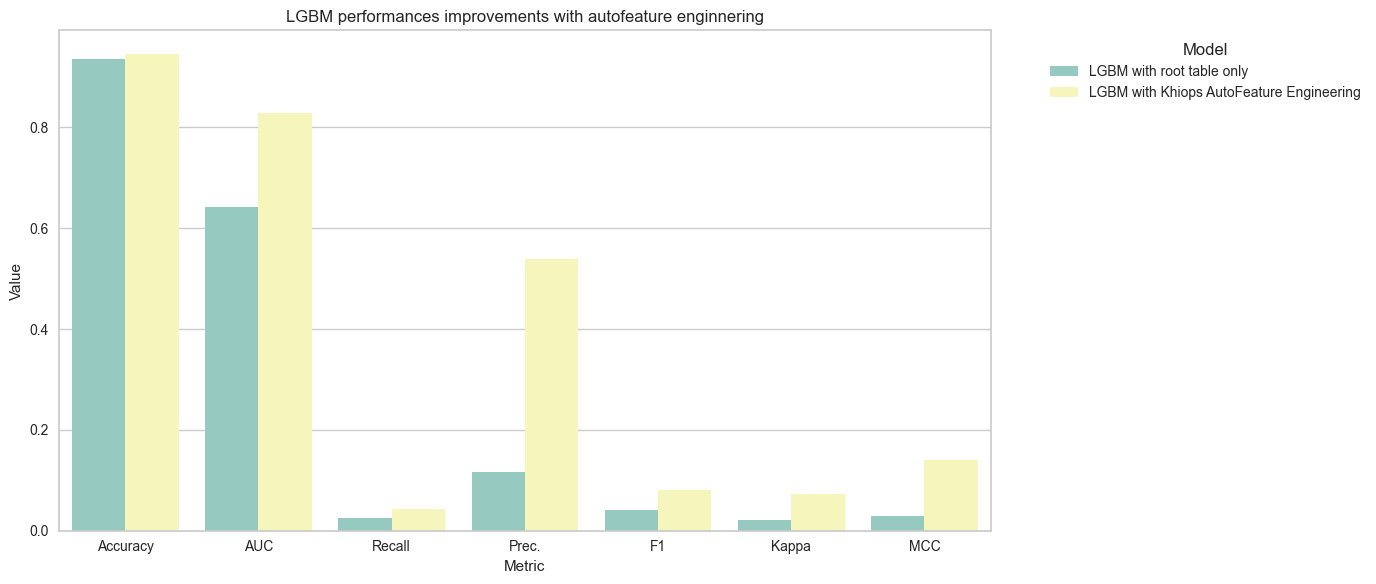

In [17]:
df_plot = results_lgbm.drop("TT (Sec)",axis=1).melt(id_vars=['Model'], var_name='Metric', value_name='Value')

plt.figure(figsize=(14, 6))

# Create a bar plot with Seaborn
sns.barplot(x='Metric', y='Value', hue='Model', data=df_plot, palette="Set3")

plt.title("LGBM performances improvements with autofeature enginnering")
plt.ylabel('Value')
plt.xlabel('Metric')

plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Finally, when we compare the performance of the LGBM classifier using, or not, the aggregates generated by Khiops, we appreciate the extent to which the Auto Feature Engineering algorithm is able to extract useful information from the secondary tables. This work would have been painstaking to do by hand, requiring numerous interactions between the data scientist and the business experts, and a great deal of trial and error.  

## Boosting model interpretability with Khiops' end-to-end pipeline

In this section, we use the complete pipeline provided by Khiops, which chains Auto Feature Engineering and Parsimonious Training through a simplistic syntax (a simple fit function). 
Using this pipeline has a number of advantages, it considerably improves model interpretability, it's ultra-easy to use, and it scales very well. 


In [18]:
# we use a KhiopsClassifier to leverage the full pipeline
pkc_accidents = KhiopsClassifier(n_trees=0, n_features=1000)

# Just fit it ! 
pkc_accidents.fit(X_accidents_train, y_accident_train)

KhiopsClassifier(auto_sort=True, internal_sort=None, key=None, n_features=1000,
                 n_pairs=0, n_trees=0, output_dir=None, verbose=False)

In [19]:
# Let's take a look at the classifier's performance on the training set
train_eval = pkc_accidents.model_report_.train_evaluation_report.get_snb_performance()

In [20]:
print(f"Accident train accuracy: {train_eval.accuracy}")
print(f"Accident train AUC     : {train_eval.auc}")

classes = train_eval.confusion_matrix.values
confusion_matrix = pd.DataFrame(
    train_eval.confusion_matrix.matrix,
    columns=classes,
    index=classes,
)
print("Accident train confusion matrix:")
confusion_matrix

Accident train accuracy: 0.94488
Accident train AUC     : 0.820184
Accident train confusion matrix:


,0,1
0,54588,3176
1,9,10


Now let's take a closer look at the trained model, by examining the aggregates generated by the Auto Feature Engineering step and selected by Paricimonuous Training. The next cell shows the names of the selected aggregates, sorted by decreasing *weight*, and the *level* is also displayed: 

- the *level* measures the extent to which the variable is correlated with the target, reflecting the importance of the variable on its own (more details [here][encoding]). 
- the *weight* measures the importance of the variable within the learned classifier, reflecting the information provided by this variable orthogonally to the others (more details [here][parsimonious_training]).

[encoding]: ../../../learn/preprocessing/#benefits
[parsimonious_training]: ../../../learn/learning_models/

In [21]:
kpis = {"Feature" : [], "Level": [], "Weight": []}

for var in pkc_accidents.model_report_.modeling_report.get_snb_predictor().selected_variables:
    kpis["Feature"].append(var.name)
    kpis["Level"].append(var.level)
    kpis["Weight"].append(var.weight)

    
df_kpis = pd.DataFrame(kpis).sort_values(by = 'Weight', ascending=False)
df_kpis.head(10).style.set_properties(subset=['Feature'], **{'width': '400px'})

,Feature,Level,Weight
30,Count(Vehicles) where Category = Car<=3.5T,0.000851,1.000000
2,Mode(Vehicles.Category) where Category <> Car<=3.5T,0.025018,0.548828
22,Mode(Vehicles.ImpactPoint) where Category <> Car<=3.5T,0.002125,0.531250
1,Department,0.050247,0.404297
10,Mode(Vehicles.FixedObstacle) where Category <> Car<=3.5T,0.006917,0.402344
14,PostalAddress,0.005056,0.398438
3,CollisionType,0.037656,0.351318
5,Mode(Vehicles.Maneuver) where Category = Car<=3.5T,0.025698,0.343750
38,Weather,0.001443,0.339844
27,CountDistinct(Vehicles.Direction) where PassengerNumber <= 0.5,0.003016,0.332031


As shown in the previous cell, the aggregates generated by khiops are identified by their calculation formula, which greatly facilitates their interpretation. For example, here's what the first three aggregates mean: 

- "Count(Vehicles) where Category = Car<=3.5T" is the number of light car involved in the accident;
- "Mode(Vehicles.Category) where Category <> Car<=3.5T" is the majority vehicle type, excluding light cars;
- "CountDistinct(Vehicles.Direction)" is the number of different directions taken by the vehicles involved.  

In practice, the models trained by khiops are easy to understand and make it easy to interact with technical experts. To make the link with the figure in the introduction to this notebook, let's now look at how the size of the data representation evolves throughout the pipeline:


In [22]:

# nb generated vs. selected features : 5 -> 1000 -> 58
Nb_original_features = len(df_accident_train.head())
Nb_selected_features = len(df_kpis)

print("Nb original features  = " + str(Nb_original_features))
print("Nb generated features = 1000")
print("Nb selected features  = " + str(Nb_selected_features))


Nb original features  = 5
Nb generated features = 1000
Nb selected features  = 56


This training pipeline starts with 5 features in the main table. The Auto Features Engineering step generates 1000 aggregates (this is a maximum number provided by the user). Then, the Parcimonious Training step selects 58 features out of all those available, in order to find the smallest subset of variables that are collectively the most informative and the most independent of each other. In the end, the resulting model is both accurate and easy to interpret. For more in-depth model interpretation, please consult the page describing the [visualization tool][visu] supplied with Khiops.

[visu]: ../../../setup/visualization/